# Adaptive Grid Discretizations
## Volume : Algoritmic tools
## Part : Domain representation
## Chapter : Subsets of $R^d$

This notebook shows how to describe a simple subset of $R^d$, and to compute finite differences taking into account a given Dirichlet data on the boundary. It is a prerequisite to the implementation of monotone schemes on non-rectangular domains.

*Note:* The library presented in this notebook features some elementary primitives of algorithmic geometry. However, their expressivity is rather limited, and exact predicates are not implemented. Therefore, please consider using a dedicated computational geometry package if you intend to go much beyond the basic examples presented in this series of notebooks.

In [11]:
import sys; sys.path.append("..") # Allow imports from parent directory
#from Miscellaneous import TocTools; TocTools.displayTOC('SubsetRd','Algo')

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Geometric methods](#1.-Geometric-methods)
    * [1.1 Base domains, union, intersection, complement](#1.1-Base-domains,-union,-intersection,-complement)
    * [1.2 Level set function](#1.2-Level-set-function)
    * [1.3 Distance to the boundary in a given direction.](#1.3-Distance-to-the-boundary-in-a-given-direction.)
  * [2. Finite differences](#2.-Finite-differences)
    * [2.1 Upwind finite differences](#2.1-Upwind-finite-differences)
    * [2.2 Centered finite differences](#2.2-Centered-finite-differences)
    * [2.3 Second order finite differences](#2.3-Second-order-finite-differences)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Import the required libraries

In [12]:
from NumericalSchemes import Domain 
from NumericalSchemes import AutomaticDifferentiation as ad

In [13]:
import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

In [14]:
def reload_packages():
    import importlib
    Domain = importlib.reload(sys.modules['NumericalSchemes.Domain'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.reload_submodules()

## 1. Domain description

The provided library allows to define a family of basic shapes, combine them with boolean operations, and affine transformations. Once the desired shape is constructed, two main functions are available: a level set map, and the distance to the boundary along a given half line.

### 1.1 Basic shapes, boolean operations, affine transformation.

Define a ball and a box domain, here in dimension two, but these primitives are dimension independent.
* *Ball* $\{x\in R^d;\, \|x-x_0\| \leq r\}$ with parameters $(x_0,r)$, the center and the radius (defaults to one).
* *Box* $[a_1,b_1] \times [a_n,b_n]$, a product of intervals.

In [15]:
ball = Domain.Ball([0,0]) # Two dimensional ball centered at the origin with radius one.
box = Domain.Box([[0,1],[0,1]]) # Square domain [0,1]x[0,1]

The standard boolean operations allow to combine elementary shapes: intersection, union, and relative complement.

In [16]:
cap = Domain.Intersection( (ball,box) )
cup = Domain.Union((ball,box))
compl = Domain.Complement(ball,box)

Bands and Convex polygons are some potentially useful additional shapes:
* *Band* $\{x\in R^d; b_0 \leq <x,v> \leq b_1$, depending on $(v,b)$, where $v$ is called the direction and $b=(b_0,b_1)$ the bounds. 
* *Convex polygon* $\mathrm{Hull}(x_1,\cdots,x_n)$. This primitive is two dimensional only.

In [17]:
band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds
triangle = Domain.ConvexPolygon(np.stack([[1.,0.],[0.,1.],[-1.,-1.]],axis=1))

An affine transformation can be applied to the domain, with parameters:
* *A* (mult) the matrix of the linear part. (defaults to identity)
* $x_0$ (center) the center of the previous linear transformation. (defaults to the origin)
* $v$ (shift) a translation to be applied. (defaults to zero)

The direct mapping takes the form
$$
    x \mapsto A (x-x_0)+x_0 + v
$$

In [18]:
def rot(t): c,s = np.cos(t),np.sin(t); return np.array(((c,-s),(s,c)))    
aff = Domain.AffineTransform(cup,0.7*rot(np.pi/3.),shift=[-0.2,-0.2])

In [19]:
doms = (ball,box,cap,compl,cup,band,triangle,aff)
domNames = ("ball","box","cap","compl","cup","band","triangle","affine")

Let us display the domains.

In [20]:
aX=np.linspace(-1.2,1.2)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
h=aX[1]-aX[0]

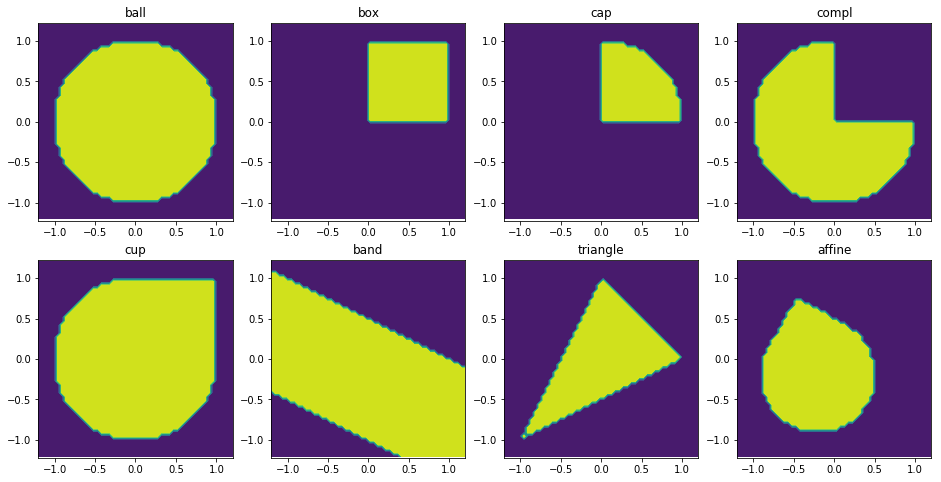

In [21]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.contains(X))
    plt.title(name)
    plt.axis('equal')

It is possible to select the points around which the domain contains a ball of a given radius $h$, possibly negative. This predicate is only approximate.

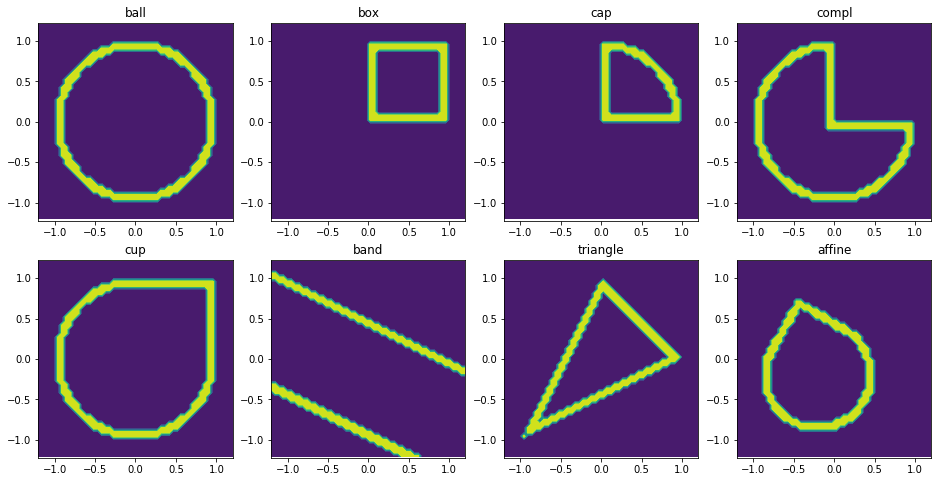

In [22]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    
    interior = dom.contains(X)
    erosion = dom.contains_ball(X,2*h)
    boundary_layer = np.logical_and(interior,np.logical_not(erosion))
    
    plt.contourf(*X,boundary_layer)
    plt.title(name)
    plt.axis('equal')

### 1.2 Level set function

Each domain comes equipped with a level set function, that is negative inside the domain, and positive outside. It is also guaranteed to be $1$-Lipschitz. 

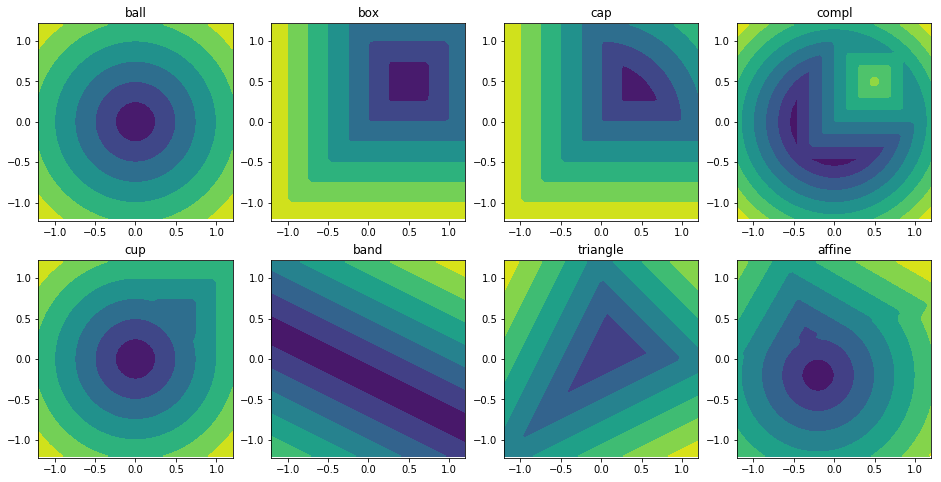

In [23]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.level(X))
    plt.title(name)
    plt.axis('equal')

This level set function is in general different from the signed Euclidean distance to the boundary.  
If you do need the Euclidean distance function, you may consider solving an eikonal equation, or using an adequate computational geometry package.

### 1.3 Distance to the boundary in a given direction.

For the design of finite difference schemes, it is important to know the distance from a given point to the domain boundary in a given direction. This is referred to as the "free way" from $x$ in the direction $v$.

In [24]:
#Domain = importlib.reload(Domain)
#ball = Domain.Ball(np.array([0,0]))
#box = Domain.Box([[0,1],[0,1]])
#cap = Domain.Intersection( (ball,box) )
#abox = Domain.AbsoluteComplement(box)
#aball = Domain.AbsoluteComplement(ball)
#compl = Domain.Complement(ball,box)
#cup = Domain.Union((ball,box))
#acup = Domain.Intersection((aball,abox))
#band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds

/Users/mirebeau/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/mirebeau/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/mirebeau/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1203: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/Users/mirebeau/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1205: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]


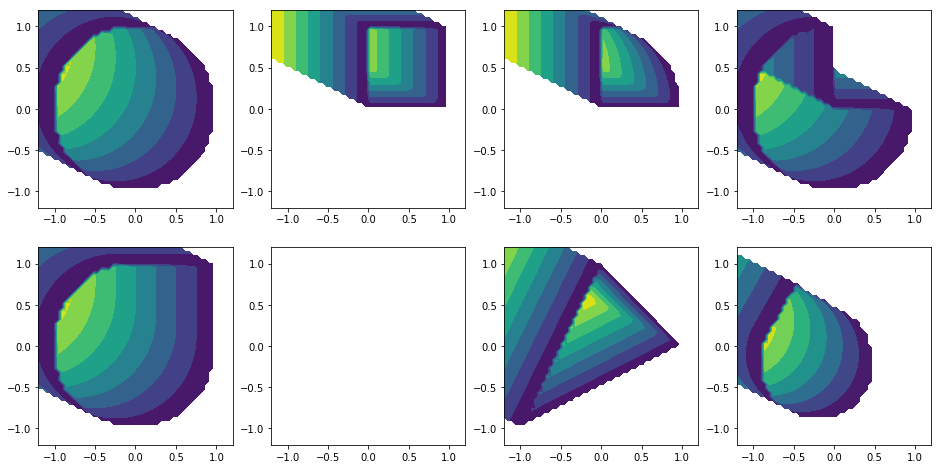

In [25]:
v=np.array([1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

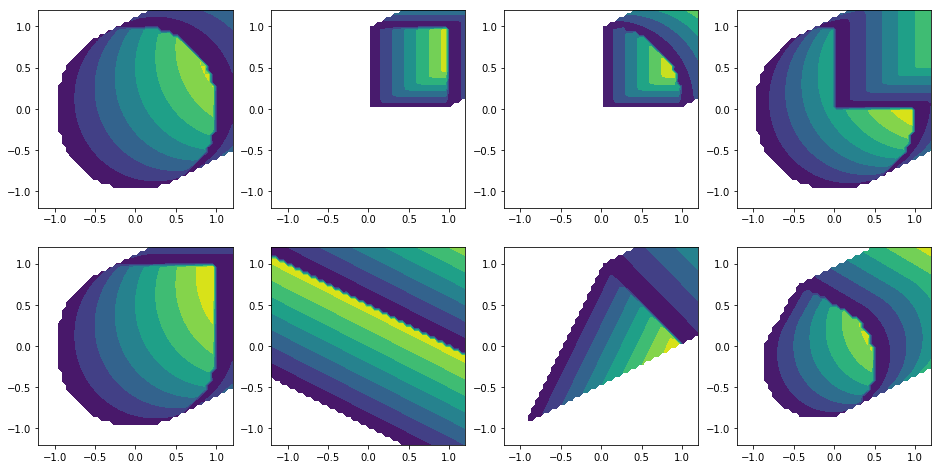

In [26]:
v=np.array([-1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

## 2. Finite differences

Presently, only Dirichlet boundary conditions are implemented. When a grid point falls outside the domain, the provided boundary data is used instead, as described below.

Denote by $\Omega$ the domain, and $\Omega_h$ its intersection with the cartesian grid $h Z^d$. Let $x\in \Omega_h$ be a point of the domain, and let $e \in Z^d\setminus \{0\}$ be an offset.

* *Upwind finite difference*.  Denote by $h_+>0$ the smallest real such that $x+h_+ e  \in \Omega_h \cup \partial \Omega$. The first order upwind finite difference is defined as
$$
    \delta^e_h u(x) := \frac{u(x+h_+e)-u(x)} {h_+}
$$
* *Centered finite difference*. The standard expression $(u(x+h e)-u(x-he))/(2h)$ is used, unless $x+ h e\notin \Omega_h$ or $x-he \notin \Omega_h$. In that case, we fall back to the upwind finite difference.
* *Second order finite difference*. Let $h_\pm>0$ denote the smallest real such that $x\pm h_\pm e \in \Omega_h \cup \partial \Omega$. The second order finite difference is defined as 
$$
    \Delta^e_h u(x) := \frac 2 {h_++h_-} \Big(\frac{u(x+h_+ e)-u(x)}{h_+} + \frac{u(x-h_- e)-u(x)}{h_-} \Big)
$$

Define the dirichlet data, based on a domain and a function defined on (at least) the boundary.
Set also the grid, underlying the finite difference scheme, and the interior points. 

It is safer to slightly erode the domain, by prescribing an interior radius $h_0>0$ which will be a lower bound for $h_+$ and $h_-$ involved in the finite differences.

In [34]:
reload_packages()

In [43]:
def bc(x): return x[0]+2*x[1]
dom = Domain.Dirichlet(cup,bc)
dom.set_grid(X,interior_radius=h/2)

### 2.1 Upwind finite differences

We choose a linear function, in order to confirm that the upwind scheme is exact in this case.

In [44]:
u = bc(X)

In [45]:
du = dom.DiffUpwind(u,(1,0),h)

In [39]:
du[interior].max(),du[interior].min()

(1.000000000000007, 0.9999999999999929)

Differentiating along the horizontal and vertical directions simultaneously.

In [47]:
du = dom.DiffUpwind(u,np.eye(2).astype(int),h)

In [48]:
du[0,interior].max(),du[0,interior].min()

(1.000000000000007, 0.9999999999999929)

In [49]:
du[1,interior].max(),du[1,interior].min()

(2.000000000000014, 1.9999999999999964)

### 2.2 Centered finite differences

Again, we choose a linear function, in order to confirm that the upwind scheme is exact in this case.

In [50]:
du = dom.DiffCentered(u,(1,0),h)

In [51]:
du[interior].max(),du[interior].min()

(1.000000000000007, 0.9999999999999929)

In [52]:
du = dom.DiffCentered(u,np.eye(2).astype(int),h)

In [53]:
du[0,interior].max(),du[0,interior].min()

(1.000000000000007, 0.9999999999999929)

In [54]:
du[1,interior].max(),du[1,interior].min()

(2.000000000000007, 1.9999999999999982)

### 2.3 Second order finite differences

The second order differences of a linear function identically vanish.

In [57]:
d2u = dom.Diff2(u,(1,0),h)

In [58]:
d2u[interior].max(),d2u[interior].min()

(3.2429064881463735e-13, -2.9013828376870805e-13)

In [59]:
d2u = dom.Diff2(u,np.eye(2).astype(int),h)

In [60]:
d2u[0,interior].max(),d2u[0,interior].min()

(3.2429064881463735e-13, -2.9013828376870805e-13)

In [61]:
d2u[1,interior].max(),d2u[1,interior].min()

(2.9013828376870805e-13, -2.9013828376870805e-13)

We need to use quadratic polynomials to illustrate consistency in a non-trivial manner.

In [62]:
def bc2(x): return x[0]**2+x[0]*x[1]
dom2 = Domain.Dirichlet(cup,bc2)
dom2.set_grid(X,interior_radius=h/2)

In [63]:
u2 = bc2(X)

In [65]:
d2u = dom2.Diff2(u2,(1,0),h)
d2u[interior].max(),d2u[interior].min()

(2.0000000000001723, 1.9999999999998097)

In [66]:
d2u = dom2.Diff2(u2,np.eye(2).astype(int),h)

In [67]:
d2u[0,interior].max(),d2u[0,interior].min()

(2.0000000000001723, 1.9999999999998097)

In [68]:
d2u[1,interior].max(),d2u[1,interior].min()

(1.4506914188435402e-13, -1.4506914188435402e-13)